# Jupyter Notebook for Validation of Results

## Overview

This notebook compares the results obtained from the two implementations, `shbundle` and `pyshbundle`, for a specific task.<br>We will focus on evaluating the following:
- Root Mean Squared Error (RMSE)
- Normalized Root Mean Squared Error (NRMSE)
- the difference in time series for a given basin.

## Evaluation Metrics

### 1. Root Mean Squared Error (RMSE)

The RMSE is a measure of the average magnitude of the errors between predicted and observed values.<br> It is calculated as follows:

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i - \bar{y}}\Big)^2}}$$

where:
- $n$ is the number of observations
- ${y_i}$ is the $i_{th}$ observation
- $\bar{y}$ is the mean of observations

### 2. Normalized Root Mean Squared Error (NRMSE)

NRMSE is a normalized version of RMSE, which provides a relative measure of the error compared to the range of the observed values. It is calculated as:

$$ NRMSE = \frac{RMSE}{\max(y) - \min(y)}$$

### 3. Difference in Time Series

We will also visually inspect the difference in time series obtained from both methods to identify any patterns or discrepancies.


## Data Preparation

Before proceeding with the analysis, ensure that the data from both `shbundle` and `pyshbundle` are loaded into the notebook.

In [54]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# import proplot
import os
from pyshbundle.hydro import BasinAvg
# import BasinAvg

Load the pre computed TWS outputs of SHBundle from the validation data folder - These have been computed using the JPL Solutions

In [55]:
''' Load tws processed data from shbundle as .mat file & from pyshbundle as xarray dataset '''
from scipy.io import loadmat
# Load the .mat file - generated by SHBundle Matlab/Octave
data_matlab = loadmat('../pyshbundle/validation_data/tws_m.mat')
# Access the variables in the .mat file
tws_mat = data_matlab['tws_m']

# Global TWS Anomaly field - computed using PySHBundle
data_py_jpl = xr.open_dataset('../pyshbundle/validation_data/tws_py.nc', engine="netcdf4")
tws_py_jpl = data_py_jpl.tws

In [56]:
data_py_jpl.attrs

{'description': 'TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km'}

Computing the TWS from scratch using the new codes follow the steps outlined in the TWS_timeseries notebook.

**NOTE** Same time step has been maintained.

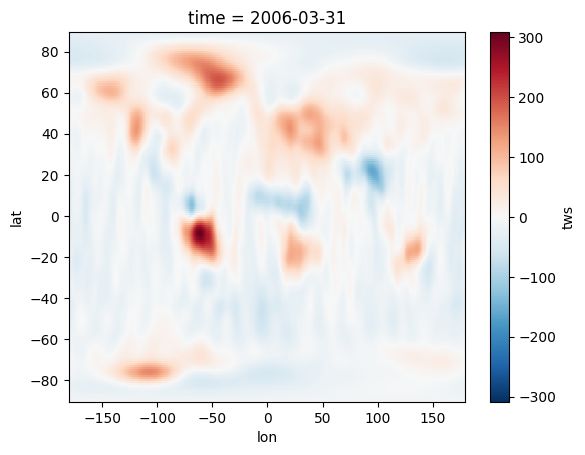

In [57]:
# Visualization - PySHBundle global TWS anomaly field - 2006-03-31
data_py_jpl.tws[50].plot()
plt.show()

In [58]:
# The PySHBundle TWS output is also of 1 deg spacing
data_py_jpl.tws[50].shape

(180, 360)

In [59]:
# The SHBundle matrix -> 1 deg spacing
(tws_mat[50, :, :]).shape

(180, 360)

In [60]:
# Transforming the SHBundle TWS Anomaly into NetCDF format to provide geocoding to the gridded TWS Anomalies

# gridsize is 1 deg which was used to compute earlier
gs = 1
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
'''
tws_py_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var2)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
'''

data_m_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_mat)
    ),
    coords = {
        "time":(('time'),data_py_jpl.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
data_m_jpl.attrs

{'description': 'TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km'}

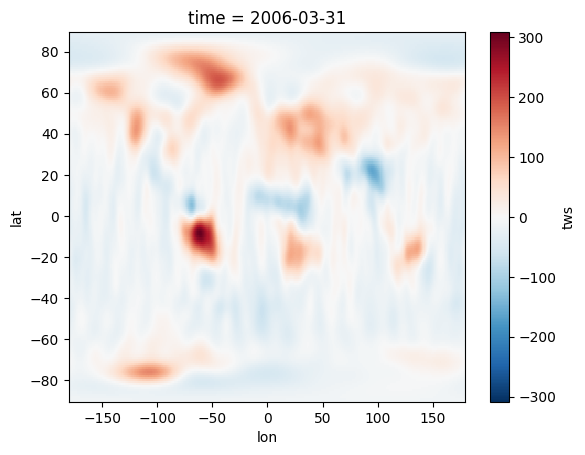

In [61]:
# SHBundle global tws field
data_m_jpl.tws.isel(time=50).plot()
plt.show()

### Gridwise RMSE calculation`

#### Creating a mask to remove the months of data which is missing (NaN)

In [62]:
nan_mask = np.all(np.isnan(data_py_jpl.tws.values), axis=(1, 2))
nan_mask

array([ True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False,

In [63]:
tws_py_jpl[~nan_mask].shape   # we see that the size of data has reduced to 196 months

(196, 180, 360)

Now that 

In [64]:
tws_m_jpl = data_m_jpl.tws

In [65]:
diff = tws_py_jpl[~nan_mask] - tws_m_jpl[~nan_mask]
squared_diff = diff**2

mean_squared_diff = np.mean(squared_diff, axis=0)
rmse = np.sqrt(mean_squared_diff)
nrmse = rmse/np.std(tws_py_jpl[~nan_mask], axis=0)
std_ = np.std(tws_py_jpl[~nan_mask], axis=0)

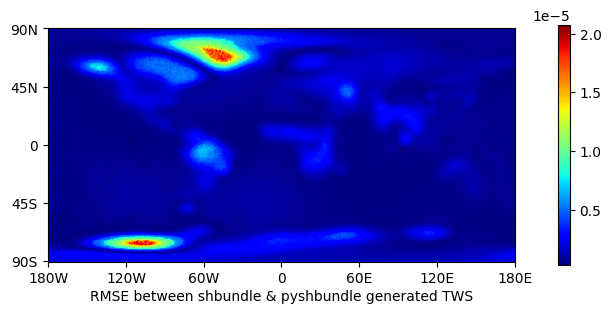

In [66]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=100, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(rmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('RMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


#plt.savefig('../pyshbundle/pic/02_error_rmse.png')
plt.show()

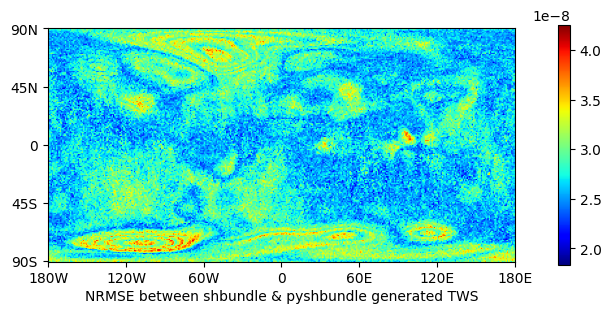

In [67]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=100, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(nrmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('NRMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


#plt.savefig('../pyshbundle/pic/02_error_nrmse.png')
plt.show()

### `Basin avg RMSE` - Amazon Basin

In [68]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

In [69]:
# import shapefile
path='../pyshbundle/data/basin_shapefiles/amazon_basin.shp'
basin_shp = gpd.read_file(path)

NOTE: In order to measure areas from these geometries the appropriate system EPSG:32644 - WGS 84 / UTM zone 44N

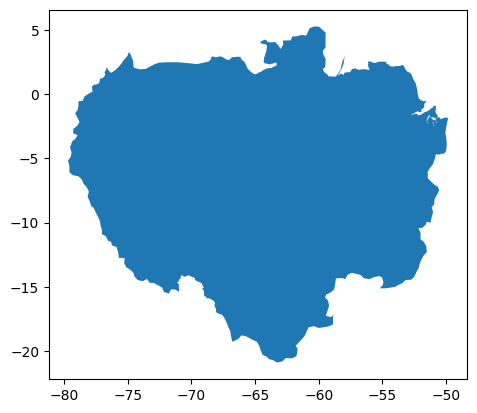

In [70]:
basin_shp.plot()
plt.show()

In [71]:
(data_py_jpl.tws).shape

(252, 180, 360)

In [72]:
# its WGS84
basin_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [73]:
basin_shp.to_crs('EPSG:24882', inplace=True)


In [74]:
# in m^2
basin_area = basin_shp.area.sum()
print(f'{basin_area/(10**6)} km2')

6499645.5323355235 km2


`BasinAvg` simply computes the basin averaged field from the passed field in netcdf format and shapefile to clip.

Here we compute the basin averaged field over the Amazon basin using the `PySHBundle` generated Global TWS Anomaly field.

In [75]:
#tws_py_jpl = tws_py_jpl*basin_area


Area of basin in km2: 131191880.87316437


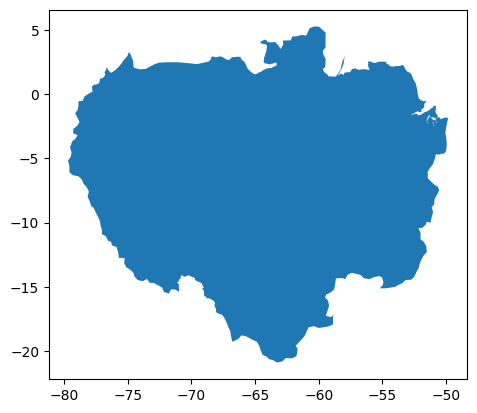

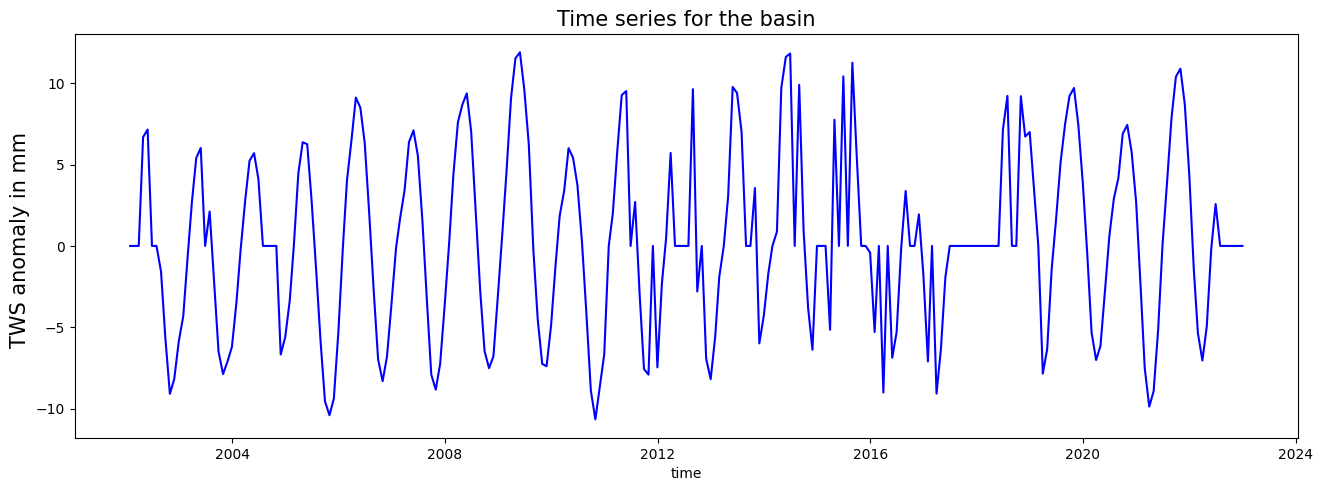

In [76]:
basin_tws_py_jpl, data_vars_py = BasinAvg(data_py_jpl, path, 'epsg:32644', 252, 1)

In [77]:
type(data_vars_py)

xarray.core.dataset.Dataset

The default plot is not great... it can be imporved easily

Similarly for the data from matlab

In [78]:
data_m_jpl.tws.shape

(252, 180, 360)

Here we compute the basin averaged timeseries using the `SHBundle` computed Global TWS Anomaly field.

In [79]:
#tws_m_jpl = tws_m_jpl*basin_area

Area of basin in km2: 131191880.87316437


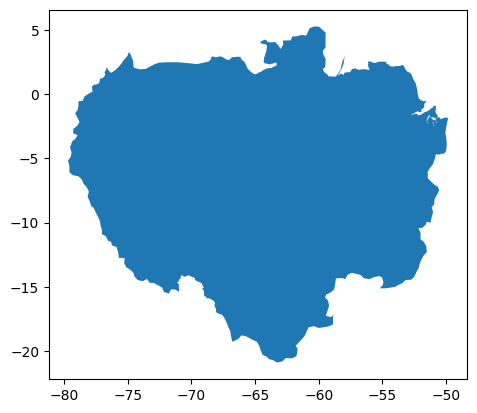

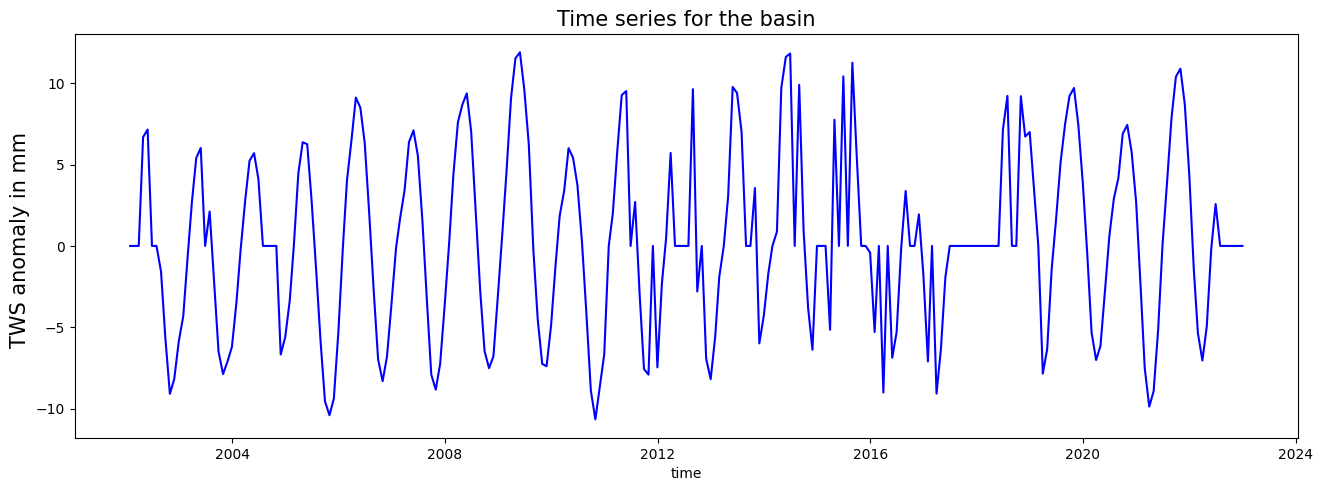

In [80]:
basin_tws_m_jpl, data_vars_m = BasinAvg(data_m_jpl, path, 'epsg:32644', 252, 1)

In [81]:
"""# clip data using shapefile
''' add projection system to nc '''
basin_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_py_jpl_ = basin_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
basin_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_m_jpl_ = basin_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws_py_jpl = basin_tws_py_jpl_.rio.clip(basin_shp.geometry.apply(mapping), basin_shp.crs,drop=False)
basin_tws_m_jpl = basin_tws_m_jpl_.rio.clip(basin_shp.geometry.apply(mapping), basin_shp.crs,drop=False)

basin_avg_tws_py_jpl = basin_tws_py_jpl.sum(dim = ('lon','lat'), skipna = True)/basin_area
basin_avg_tws_m_jpl = basin_tws_m_jpl.sum(dim = ('lon','lat'), skipna = True)/basin_area"""

'# clip data using shapefile\n\'\'\' add projection system to nc \'\'\'\nbasin_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)\nbasin_tws_py_jpl_ = basin_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)\nbasin_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)\nbasin_tws_m_jpl_ = basin_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)\n        \n# mask data with shapefile\nbasin_tws_py_jpl = basin_tws_py_jpl_.rio.clip(basin_shp.geometry.apply(mapping), basin_shp.crs,drop=False)\nbasin_tws_m_jpl = basin_tws_m_jpl_.rio.clip(basin_shp.geometry.apply(mapping), basin_shp.crs,drop=False)\n\nbasin_avg_tws_py_jpl = basin_tws_py_jpl.sum(dim = (\'lon\',\'lat\'), skipna = True)/basin_area\nbasin_avg_tws_m_jpl = basin_tws_m_jpl.sum(dim = (\'lon\',\'lat\'), skipna = True)/basin_area'

In [82]:
# diff of shbundle and pyshbundle
diff_basin_avg_tws = basin_tws_m_jpl -basin_tws_py_jpl

In [83]:
nan_mask_reshaped = np.expand_dims(nan_mask, axis=(1, 2))

In [84]:
basin_avg_tws_py_jpl = data_vars_py.where(~nan_mask_reshaped, np.nan)
basin_avg_tws_m_jpl = data_vars_m.where(~nan_mask_reshaped, np.nan)


In [85]:
diff_basin_avg_tws[nan_mask]=np.nan
diff_basin_avg_tws

<xarray.DataArray 'tws' (time: 252)> Size: 2kB
array([            nan,             nan,             nan,  1.08705773e-08,
        1.20702559e-10,             nan,             nan, -2.86565838e-09,
       -1.19029568e-08, -2.11288054e-09, -2.37374209e-09,  6.42224229e-09,
       -1.46417012e-09, -8.05550493e-09, -3.50819240e-09,  1.92753369e-08,
        3.25809779e-09,             nan, -1.98709493e-10,  2.21091812e-09,
       -4.23506563e-09, -1.70381309e-08,  1.03593738e-08,  2.66935274e-09,
       -4.88085083e-09,  1.54394299e-08,  1.87383367e-08,  2.19851426e-09,
        1.42888812e-09,  1.00631503e-10,             nan,             nan,
                   nan,             nan,  1.82328543e-08, -9.34531386e-09,
        3.33074635e-09,  1.79960404e-10, -1.12178284e-08, -1.49591752e-08,
        1.47091050e-08, -6.45122844e-09,  6.62729205e-10,  5.17488186e-09,
       -1.87561557e-08,  4.06534539e-09, -8.43310666e-09,  8.78891715e-09,
        1.31497288e-09, -1.94811545e-09, -1.06705000e-08, -6.12964612e-09,
        2.03799058e-08,  9.21673404e-10,  6.67099487e-10, -2.04631023e-09,
        8.61672156e-09, -3.74085474e-09, -1.09071774e-08, -9.66072600e-09,
        5.76021103e-09, -9.34403488e-09,  2.38451037e-10, -3.85123222e-09,
        9.89486981e-09, -3.50151730e-09,  5.82259063e-09,  1.06208509e-09,
       -9.93592231e-09,  5.89963634e-11,  1.07692175e-08, -5.55507773e-09,
        2.44273574e-10,  2.87068946e-09,  1.73609713e-08, -2.88121154e-08,
       -1.38109737e-08,  3.55957486e-09, -2.17609530e-09, -3.58896735e-09,
...
       -6.51751364e-09, -3.93523436e-09, -1.99562106e-09, -5.97951466e-10,
                   nan,             nan,  1.67517200e-09, -2.30805863e-09,
        1.04951479e-08,             nan, -7.44723394e-10,  6.50756160e-09,
       -2.78714651e-09,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  8.97206576e-09, -5.91575322e-09,             nan,
                   nan,  5.43495027e-09,  2.72235923e-09,  9.29352595e-10,
        1.53691326e-09,             nan,  3.53507978e-09,  7.00559255e-09,
        3.30855854e-09, -4.04041312e-09,  1.16008891e-09, -4.53893279e-09,
       -1.65800156e-08, -1.75149690e-08, -6.32510488e-09, -4.54218885e-11,
        1.88166605e-09,  1.82702351e-08, -9.09339803e-09,  1.64722023e-08,
       -7.52093809e-09,  4.27747060e-10, -5.36768852e-09,  3.83159193e-09,
        2.18042668e-08, -1.65551475e-08,  4.52060256e-09,  3.92664523e-09,
       -5.85033222e-09,  1.26264066e-08,  2.37407143e-08, -4.43568382e-09,
        4.68977301e-09, -2.92299542e-09,  2.16801244e-09, -6.95224323e-09,
       -8.10118195e-09,  4.90718222e-09,  1.53619570e-08,  5.34221822e-09,
        4.63954564e-09, -3.76402376e-09,  8.38898284e-09, -2.72726286e-09,
       -1.05020045e-09, -8.14510237e-10,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2022-12-31

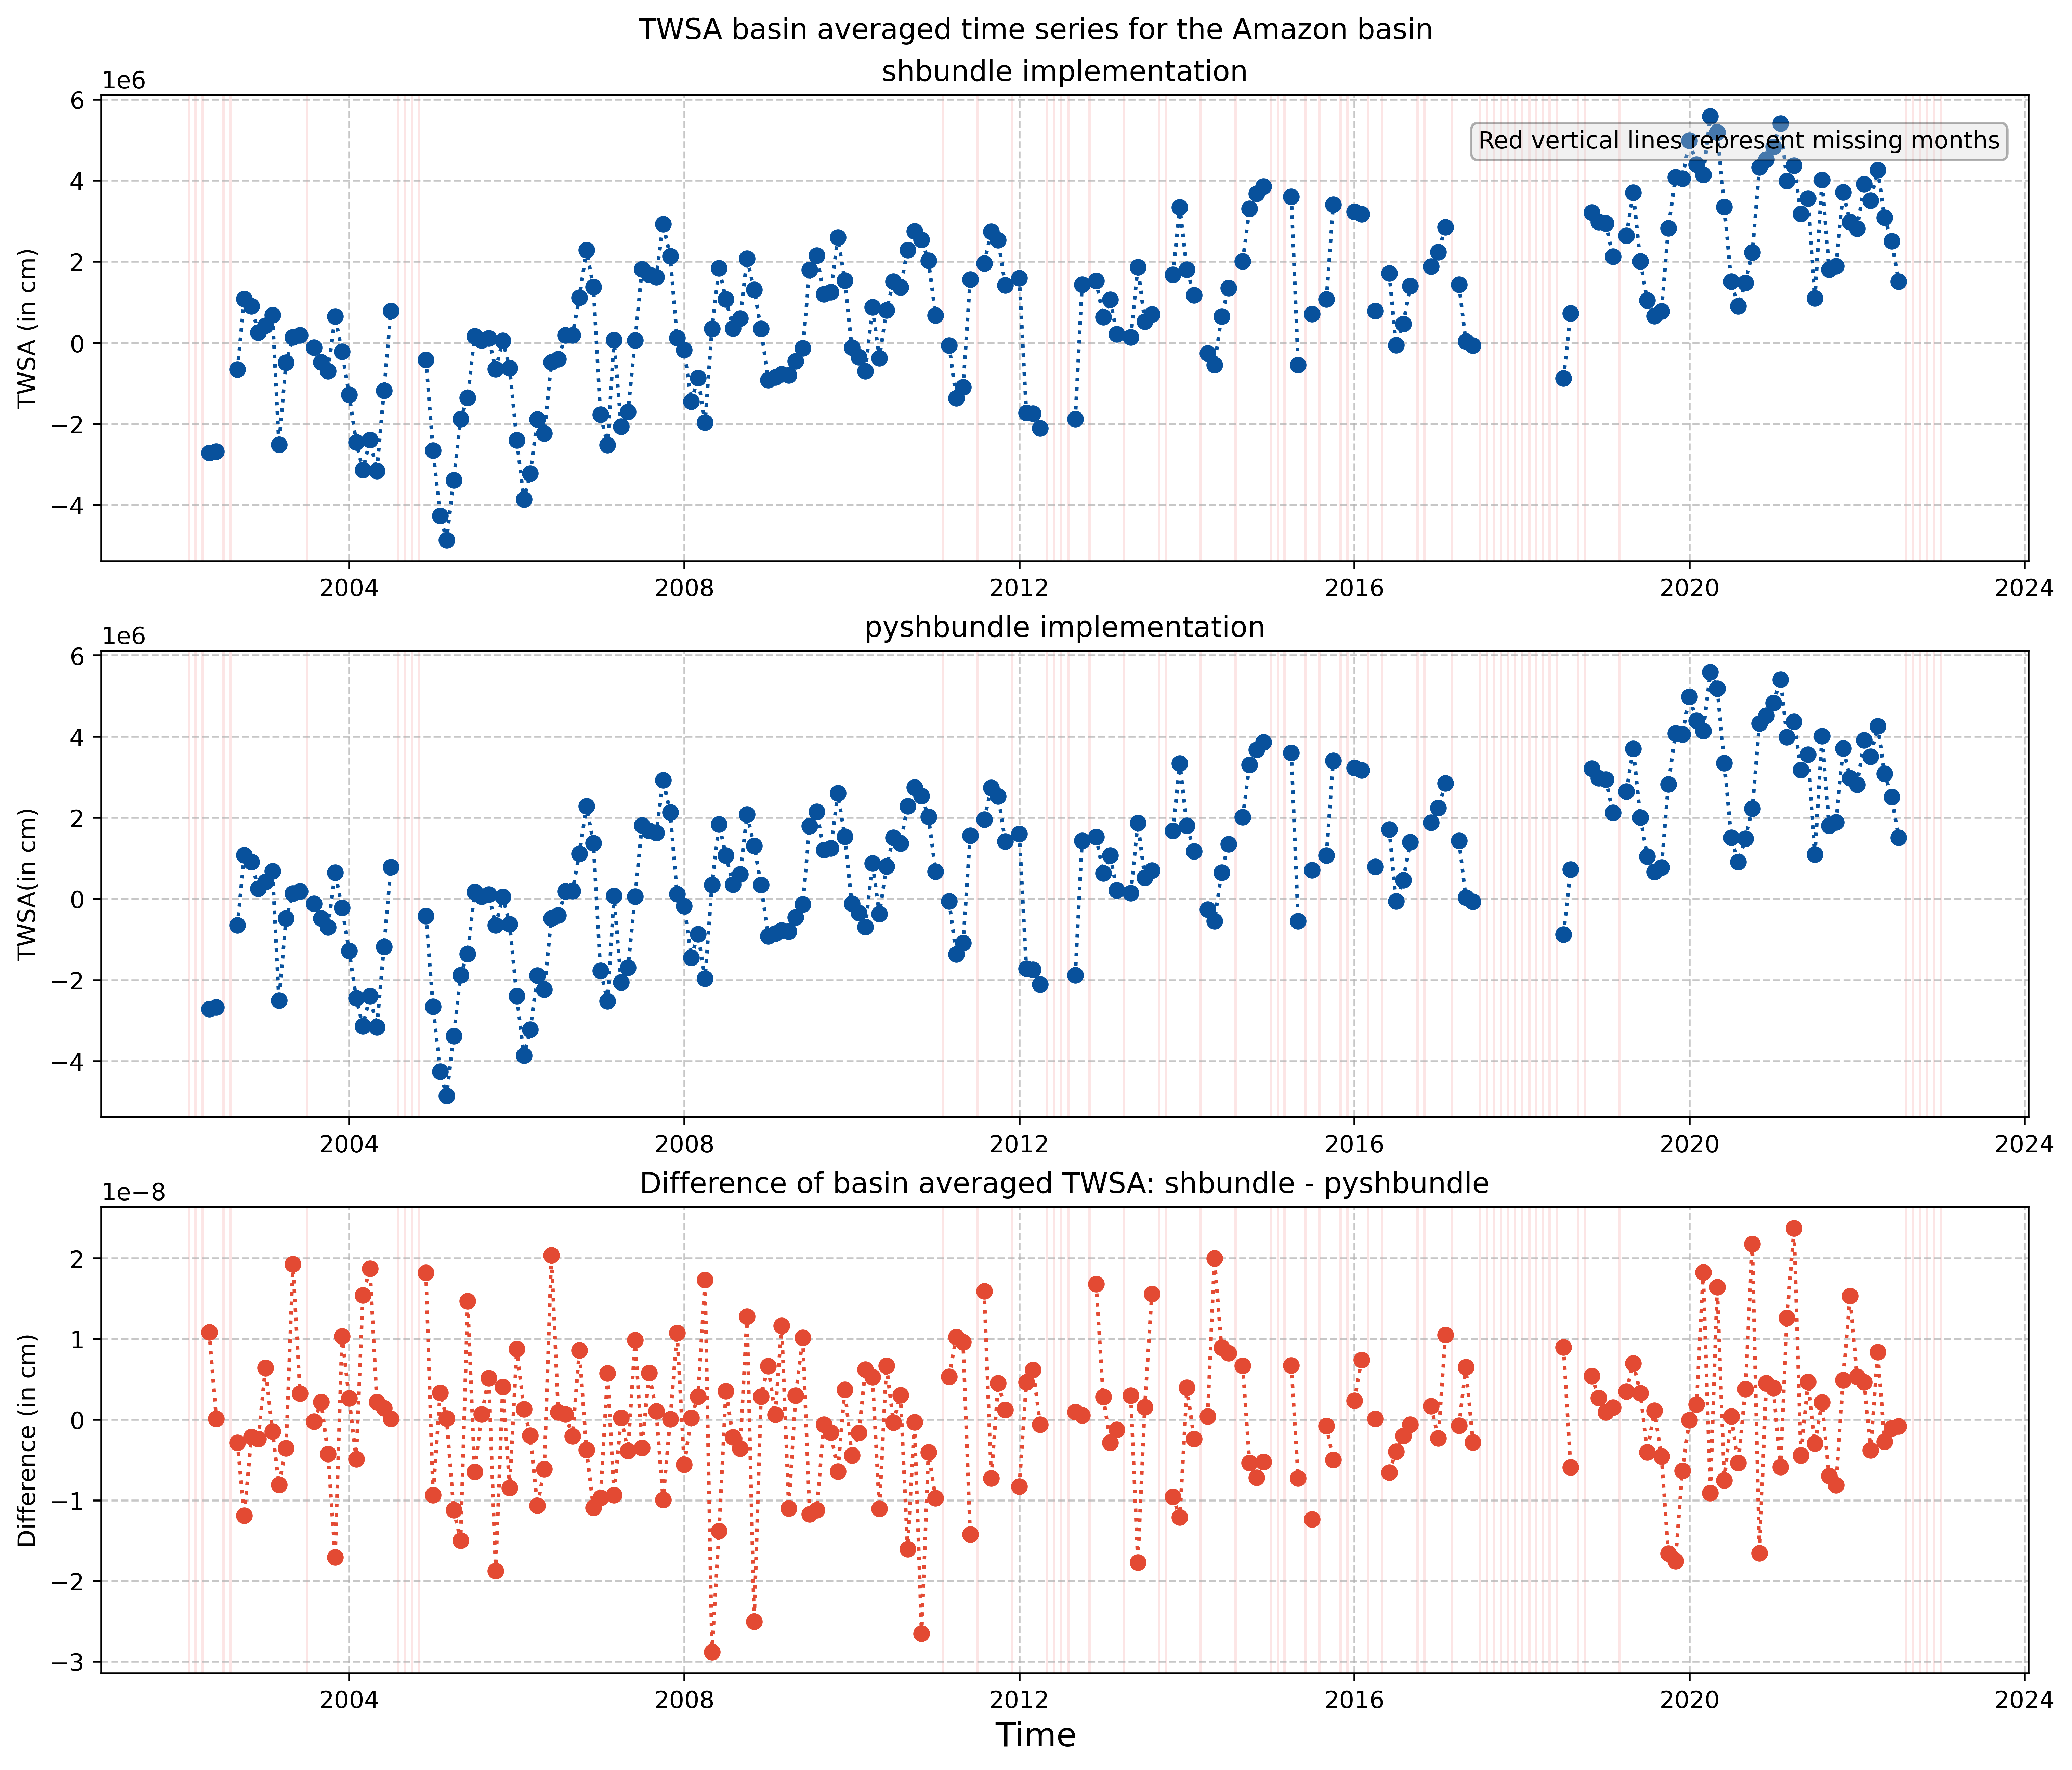

In [86]:
# Create lists for each data
data_list = [basin_avg_tws_m_jpl.tws, basin_avg_tws_py_jpl.tws, diff_basin_avg_tws]  
label_list = ['shbundle implementation', 'pyshbundle implementation','Difference of basin averaged TWSA: shbundle - pyshbundle']
# legend_list = ['Monthly TWSA', 'Monthly TWSA', 'Difference in monthly']
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)
# Iterate over each subplot
count = 0
for i, ax in enumerate(axes):
    if count > 1:
        break
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, np.mean(data_list[i], axis = (1,2)), 
            label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]}')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.85, 0.9,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
    count += 1


# Plot with a dotted line and markers
ax.plot(data_list[0].time, diff_basin_avg_tws, 
        label=label_list[i], linestyle='dotted', marker='o', color=color_list[-1])

# Create vertical shaded regions for missing values
nan_variables = data_list[0].time.values[nan_mask]
for xc in nan_variables:
    ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

# Add labels and title

ax.set_ylabel(ylabel_list[-1])
ax.set_title(f'{label_list[-1]}')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend
# ax.legend(fancybox=True, edgecolor='black', loc="upper left")
# Add text box only in the first subplot
if i == 0:
    ax.text(
        0.85, 0.9,  # Position of the text box (relative to the subplot)
        'Red vertical lines represent missing months',  # Text content
        transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
        ha='center', va='center',  # Center the text
        bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
    )

# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
# fig.suptitle(f'TWSA basin averaged time series for {basin_name}')
fig.suptitle(f'TWSA basin averaged time series for the Amazon basin')
plt.show()
# fig.savefig(f'../pyshbundle/pic/03_basin_avg_tws_{basin_name}.png')

### 2. `Basin avg RMSE` - Krishna Basin

In [88]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

In [89]:
# import shapefile
path='../pyshbundle/data/basin_shapefiles/krishna_basin.shp'
basin_shp = gpd.read_file(path)

NOTE: In order to measure areas from these geometries the appropriate system EPSG:32644 - WGS 84 / UTM zone 44N

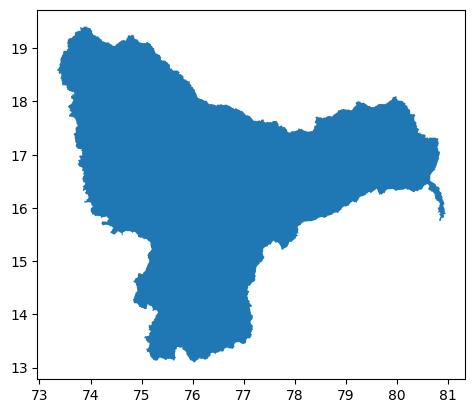

In [90]:
basin_shp.plot()
plt.show()

In [91]:
(data_py_jpl.tws).shape

(252, 180, 360)

In [92]:
# its WGS84
basin_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [93]:
basin_shp.to_crs('EPSG:32643', inplace=True)


In [94]:
# in m^2
basin_area = basin_shp.area.sum()
print(f'{basin_area/(10**6)} km2')

258093.7823666634 km2


`BasinAvg` simply computes the basin averaged field from the passed field in netcdf format and shapefile to clip.

Here we compute the basin averaged field over the Amazon basin using the `PySHBundle` generated Global TWS Anomaly field.

In [95]:
#tws_py_jpl = tws_py_jpl*basin_area


Area of basin in km2: 259412.73935151333


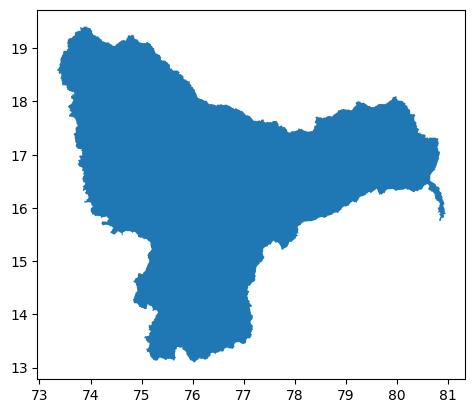

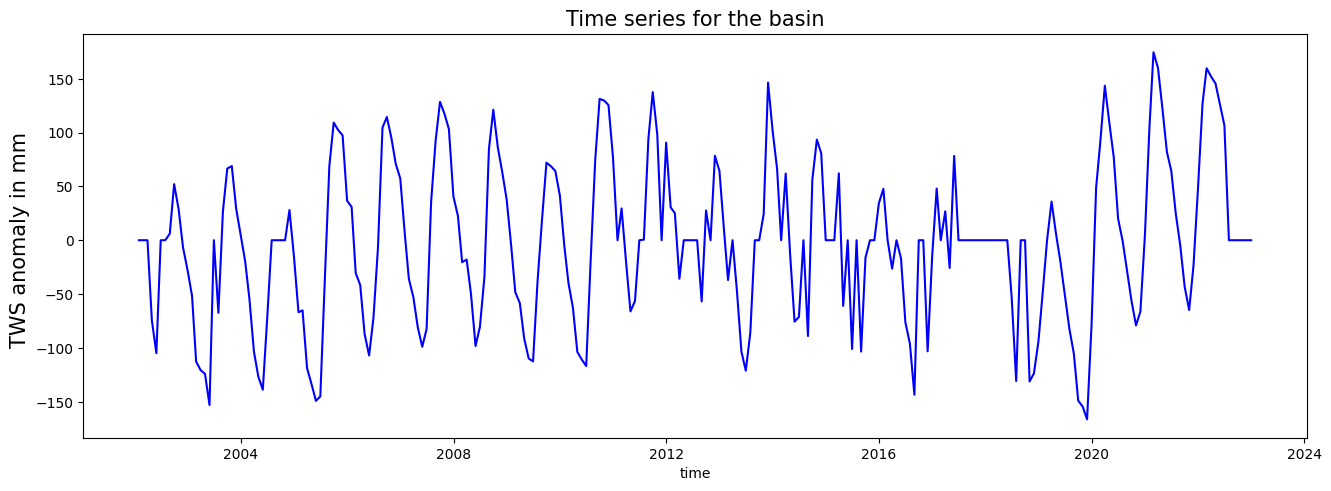

In [96]:
basin_tws_py_jpl, data_vars_py = BasinAvg(data_py_jpl, path, 'epsg:32644', 252, 1)

In [97]:
type(data_vars_py)

xarray.core.dataset.Dataset

The default plot is not great... it can be imporved easily

Similarly for the data from matlab

In [98]:
data_m_jpl.tws.shape

(252, 180, 360)

Here we compute the basin averaged timeseries using the `SHBundle` computed Global TWS Anomaly field.

Area of basin in km2: 259412.73935151333


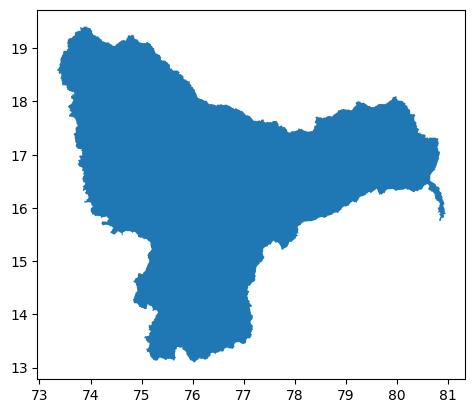

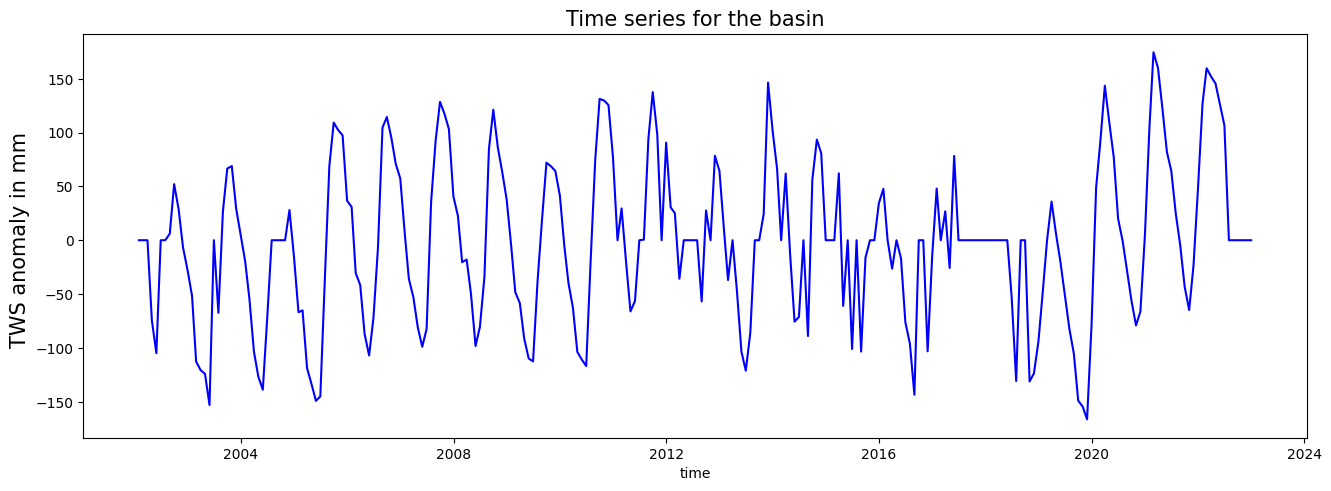

In [99]:
basin_tws_m_jpl, data_vars_m = BasinAvg(data_m_jpl, path, 'epsg:32644', 252, 1)

In [100]:
# diff of shbundle and pyshbundle
diff_basin_avg_tws = basin_tws_m_jpl -basin_tws_py_jpl

In [101]:
nan_mask_reshaped = np.expand_dims(nan_mask, axis=(1, 2))

In [102]:
basin_avg_tws_py_jpl = data_vars_py.where(~nan_mask_reshaped, np.nan)
basin_avg_tws_m_jpl = data_vars_m.where(~nan_mask_reshaped, np.nan)


In [103]:
diff_basin_avg_tws[nan_mask]=np.nan
diff_basin_avg_tws

<xarray.DataArray 'tws' (time: 252)> Size: 2kB
array([            nan,             nan,             nan, -9.66749866e-07,
        2.36239060e-07,             nan,             nan,  8.70866002e-08,
       -1.21967652e-07,  4.76771902e-08,  6.79261651e-08, -1.37407021e-07,
        1.00828430e-08, -7.44594274e-07,  9.87252932e-07,  5.13133358e-07,
       -2.69476317e-07,             nan, -5.99558376e-07, -3.09184074e-08,
        6.26554751e-07, -5.54571656e-07,  3.75930689e-07, -5.69014027e-08,
        2.16673701e-07,  3.39144684e-07,  8.06979955e-07,  1.29026483e-06,
        5.09499273e-07, -9.77998695e-08,             nan,             nan,
                   nan,             nan,  1.06050287e-07,  8.65936478e-09,
       -7.26102314e-07,  2.52397172e-07, -1.59463582e-07, -2.06497933e-06,
        8.37894589e-07, -2.75577037e-07,  9.96213174e-08,  7.66554450e-07,
        5.34747770e-07, -6.22134223e-07, -3.17454706e-07, -5.30381854e-08,
       -1.18136541e-08, -7.08983698e-08, -5.06167197e-08,  3.88393588e-07,
        1.03801298e-07,  4.56511430e-07, -4.58372718e-09,  2.88082617e-07,
       -1.25152587e-06,  7.79984077e-09,  1.07604961e-07, -3.84524569e-07,
        2.34004593e-08, -2.30620842e-07, -3.59828370e-07,  2.06875299e-07,
       -1.33501985e-07, -5.04453908e-07,  4.23010604e-07,  1.33067672e-07,
        1.30207866e-07,  9.84328921e-07, -2.09836770e-08,  7.33673176e-08,
       -8.92852725e-09, -9.89332136e-08,  1.29348543e-07, -1.77999866e-07,
       -5.88692899e-07,  1.17683071e-06, -3.20407381e-08, -1.74728669e-07,
...
       -6.76620147e-08,  6.37513580e-08, -5.69453960e-08, -1.35222072e-06,
                   nan,             nan, -2.58301327e-08,  1.28050342e-07,
       -1.59834151e-07,             nan, -7.20859816e-10,  1.00569689e-07,
        8.50826197e-07,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  2.22182592e-07,  9.04142752e-07,             nan,
                   nan,  8.11870109e-07, -2.42498757e-07,  8.58122263e-07,
        4.79937569e-07,             nan,  4.95092110e-08, -3.20566862e-08,
       -1.31901089e-07,  1.98246084e-07,  2.75384593e-07,  3.47873481e-08,
       -5.63719311e-07,  1.98856782e-07,  1.41791492e-06, -1.74688608e-07,
        1.63649453e-07,  4.74997876e-07, -6.58756960e-08, -1.96630836e-07,
        3.17947979e-07, -2.35486461e-07, -2.60734814e-08,  1.02065204e-07,
        1.43819889e-08, -2.40661379e-07,  1.09411189e-07,  1.70878218e-08,
       -4.56124113e-07,  3.94602949e-07, -2.17781897e-06, -4.79526108e-07,
       -8.19624233e-07, -6.14087497e-07, -1.20466467e-07, -3.08205887e-08,
        1.51560485e-07,  4.49916513e-07,  4.06160083e-09,  3.62997362e-07,
       -2.96221529e-07,  6.91647045e-07,  8.73708927e-08, -6.20568073e-07,
        6.40042401e-07, -5.42319583e-07,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2022-12-31

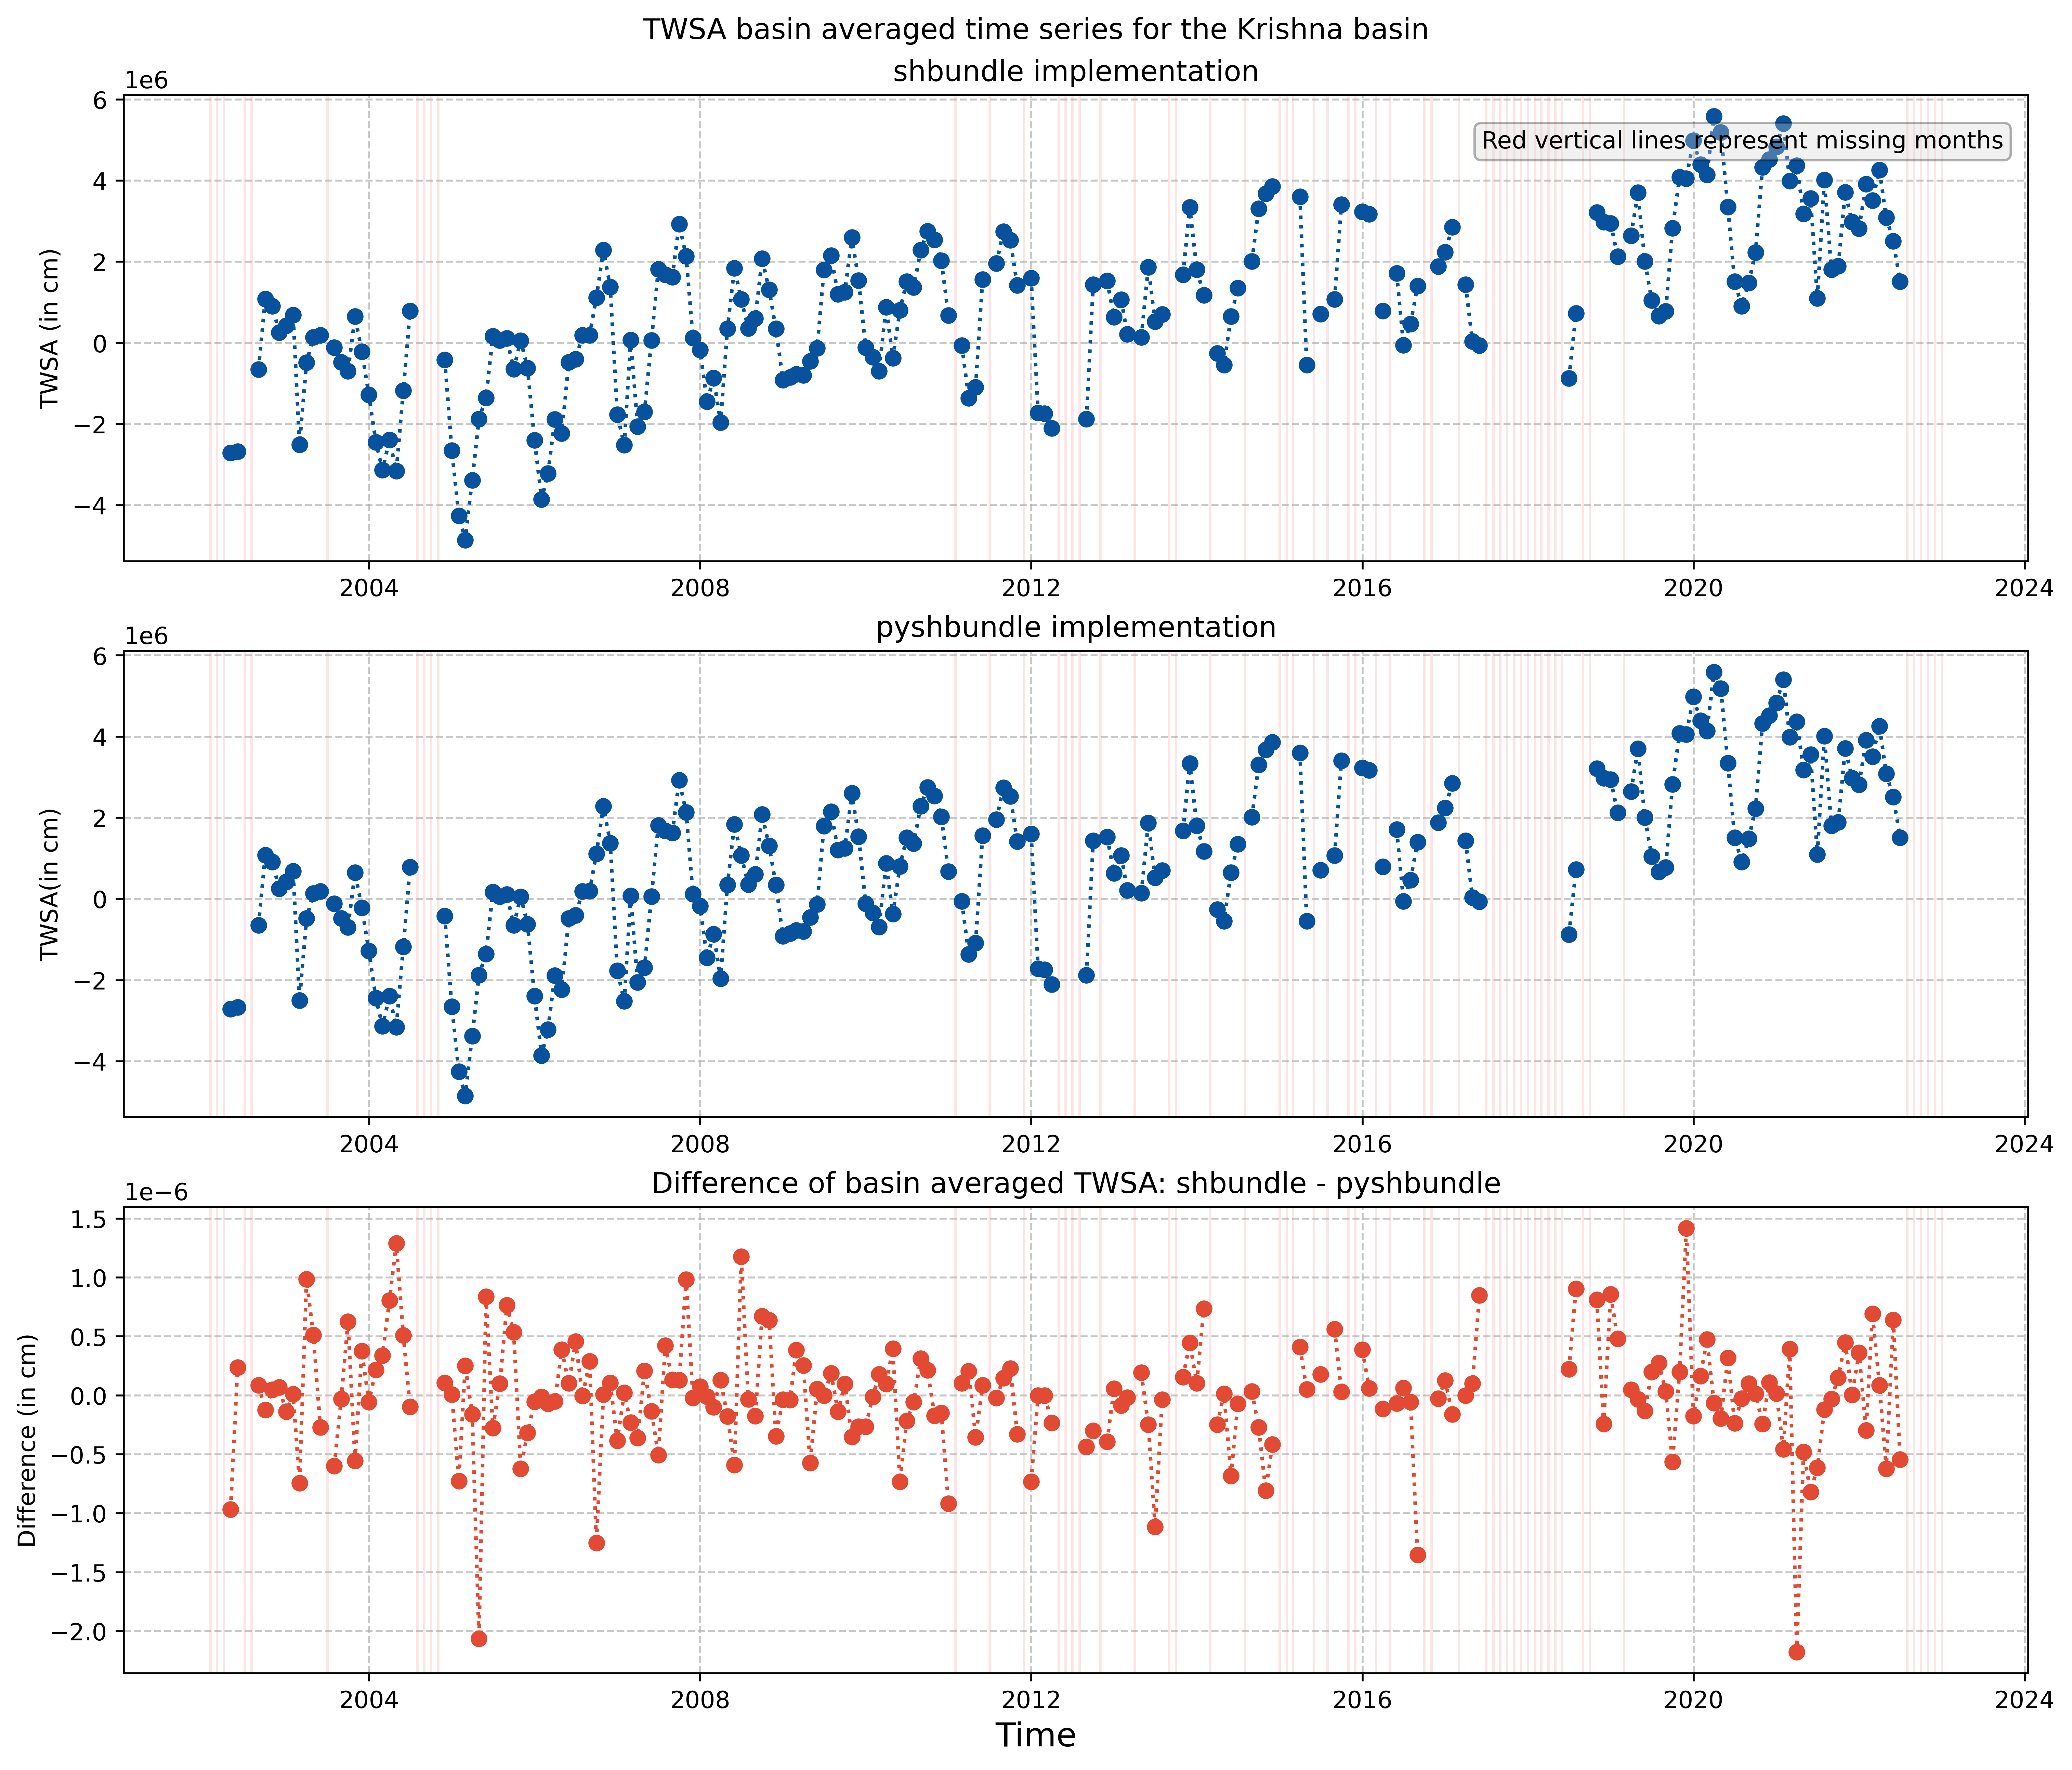

In [104]:
# Create lists for each data
data_list = [basin_avg_tws_m_jpl.tws, basin_avg_tws_py_jpl.tws, diff_basin_avg_tws]  
label_list = ['shbundle implementation', 'pyshbundle implementation','Difference of basin averaged TWSA: shbundle - pyshbundle']
# legend_list = ['Monthly TWSA', 'Monthly TWSA', 'Difference in monthly']
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)
# Iterate over each subplot
count = 0
for i, ax in enumerate(axes):
    if count > 1:
        break
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, np.mean(data_list[i], axis = (1,2)), 
            label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]}')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.85, 0.9,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
    count += 1


# Plot with a dotted line and markers
ax.plot(data_list[0].time, diff_basin_avg_tws, 
        label=label_list[i], linestyle='dotted', marker='o', color=color_list[-1])

# Create vertical shaded regions for missing values
nan_variables = data_list[0].time.values[nan_mask]
for xc in nan_variables:
    ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

# Add labels and title

ax.set_ylabel(ylabel_list[-1])
ax.set_title(f'{label_list[-1]}')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Add a legend
# ax.legend(fancybox=True, edgecolor='black', loc="upper left")
# Add text box only in the first subplot
if i == 0:
    ax.text(
        0.85, 0.9,  # Position of the text box (relative to the subplot)
        'Red vertical lines represent missing months',  # Text content
        transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
        ha='center', va='center',  # Center the text
        bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
    )

# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
# fig.suptitle(f'TWSA basin averaged time series for {basin_name}')
fig.suptitle(f'TWSA basin averaged time series for the Krishna basin')
plt.show()
# fig.savefig(f'../pyshbundle/pic/03_basin_avg_tws_{basin_name}.png')